In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
import math
from typing import Optional, Literal


In [2]:
base_data = pd.read_csv(('U://DATA/OpenClassrooms/Data science/P5/data_fro_clustering.csv'))

**Let's write some helper function**

In [32]:

def create_dendrogram(
        df:pd.DataFrame,
        scaler : Literal['standardscaler','robustscaler'] = 'standardscaler',
        linkage_methode : Optional[Literal['ward', 'single', 'complete','average']] = 'ward'
        ):
    """
    - df : Put the dataframe of the data you want to perform AHC on.
    - scaler : how do you want to scale the data
    - linkage_methode : How should the distance between clusters be calculated
    """
    #Scale the data
    _scaler = StandardScaler() if scaler == 'standardscaler' else RobustScaler()
    df_scaled = _scaler.fit_transform(df)
    # within cluster some of squares
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df_scaled)
        wcss.append(kmeans.inertia_)
    # plot the WCSS values
    plt.figure(figsize=(4, 5))
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    # Get the figure number of the first graph
    fig_num = plt.gcf().number

    # for the dendrogram
    #Distance matrix and hierarchical clustering you can change the method : single/complete/average/ward
    clustering = linkage(df_scaled, method= linkage_methode, metric='euclidean')
    plt.figure(figsize=(20, 7))
    plt.title("Dendrogram")
    plt.ylabel("Distance")
    plt.xticks(fontsize = 15)
    dendrogram(clustering, labels=df.index, leaf_rotation=90)
    plt.show()
    nbClusters = int(input('How many clusters do you want:'))
    t = findDistance(clustering, nbClusters)
    clusters = fcluster(clustering,t,criterion='distance')
    cluster_df = df.copy()
    cluster_df['Cluster'] = clusters
    plt.close(fig= fig_num)
    return cluster_df

def findDistance(linkage, nbCluster):
    """
    function used in the create_dendrogram
    """
    i = 0.5
    x = 100
    temp_x = 100
    best_i = 0
    while x > nbCluster or x != nbCluster and x > 1:
        clusters = fcluster(linkage,i,criterion='distance')
        x = len(np.unique(clusters))

        #On garde la meilleur distance au cas ou on ne trouve pas le nombre exact de cluster
        if nbCluster / x == 1 :
            return i
        elif nbCluster / temp_x < 1:
            temp_x = x
            best_i = i

        i += 0.5


    return best_i

def exploreCentroids(cluster_df:pd.DataFrame):
    """
    The dataframe must have a column named `Cluster` with the respective cluster of each rows

    - This function will draw one graph per component to show the boxplot of each cluster
    
    """
    centroids = cluster_df.groupby('Cluster').mean()
    display(centroids)
    n_components = centroids.shape[1]
    n_cluster = centroids.shape[0]
    
    #find out how many plot we need :
    if n_components <= 3:
        R = 1
        C = n_components
    else:
        R = math.ceil(n_components/3)
        C = 3
    
    #get the number of graph right:
    #AX = []
    #for x in range(1, n_components+1):
    #    AX.append('ax'+str(x))
    
    fig, axes = plt.subplots(nrows=R, ncols=C, figsize=(20, R*6))
    
    # Create boxplots for each component and cluster
    for i, column in enumerate(cluster_df.columns):
        if column == 'Cluster':
            continue
        if R > 1:  # Multiple rows
            ax = axes[i // C, i % C]
        else:  # Single row
            ax = axes[i]
        
        cluster_boxplot = cluster_df.boxplot(column=column, by='Cluster', ax=ax)
        cluster_boxplot.set_title(column)
        cluster_boxplot.set_ylabel(column)
      
    
    plt.tight_layout()
    plt.show()

def kmeansClustering(
        df:pd.DataFrame,
        scaler : Literal['standardscaler','robustscaler'] = 'standardscaler'
        ):
    """
    - df : Put the dataframe of the data you want to perform kmeans clustering on.
    - scaler : how do you want to scale the data
    """
    _scaler = StandardScaler() if scaler == 'standardscaler' else RobustScaler()
    # within cluster some of squares
    df_scaled = _scaler.fit_transform(df)
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df_scaled)
        wcss.append(kmeans.inertia_)
    # plot the WCSS values
    plt.figure(figsize=(4, 5))
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()


    nbClusters = int(input('How many clusters do you want:'))
    kmeans = KMeans(n_clusters=nbClusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(df_scaled)
    
    # Add cluster labels to the DataFrame
    cluster_df = df.copy()
    cluster_df['Cluster'] = cluster_labels + 1
    
    return cluster_df

def compare_clustering_results(df1:pd.DataFrame, df2:pd.DataFrame):
    """
    The dataframes must have a column named `Cluster` with the respective cluster of each rows
    - Give the silhouette_score for each dataframe
    The silhouette score ranges from -1 to 1, where:

A score close to +1 indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters.

A score close to 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters.

A score close to -1 indicates that the object is likely assigned to the wrong cluster.
    """
    
    # Calculate silhouette score for df1 clustering
    df1_silhouette = silhouette_score(df1.drop('Cluster', axis=1), df1['Cluster'])
    print("Silhouette Score (df1):", df1_silhouette)

    # Calculate silhouette score for df2 clustering
    df2_silhouette = silhouette_score(df2.drop('Cluster', axis=1), df2['Cluster'])
    print("Silhouette Score (df2):", df2_silhouette)


In [4]:
base_data.columns

Index(['customer_unique_id', 'frequency', 'monetary', 'review_score',
       'max_purchase_timestamp', 'min_purchase_timestamp', 'time_difference',
       'frequency_per_time'],
      dtype='object')

In [5]:
clustering_data = base_data.copy()
clustering_data_min = clustering_data.drop(columns=['customer_unique_id','min_purchase_timestamp','time_difference','frequency_per_time','review_score'])

In [6]:
clustering_data_min.sort_values('max_purchase_timestamp', ascending=False)

,frequency,monetary,max_purchase_timestamp
87272,2,290.00,2018-09-03 09:06:57
37201,1,84.99,2018-08-29 15:00:37
78982,1,24.90,2018-08-29 14:52:00
13295,1,45.90,2018-08-29 14:18:28
53586,1,209.00,2018-08-29 14:18:23
...,...,...,...
72253,1,21.90,2016-10-03 16:56:50
90547,1,100.00,2016-10-02 22:07:52
85599,1,44.99,2016-09-15 12:16:38
94471,1,59.50,2016-09-05 00:15:34


In [7]:
clustering_data_min.dtypes

frequency                   int64
monetary                  float64
max_purchase_timestamp     object
dtype: object

In [8]:
# Convert 'max_purchase_timestamp' column to datetime
clustering_data_min['max_purchase_timestamp'] = pd.to_datetime(clustering_data_min['max_purchase_timestamp'])

# Find the maximum date from the 'max_purchase_timestamp' column
max_date = clustering_data_min['max_purchase_timestamp'].max()

# Calculate recency as the number of days between today and the last order
clustering_data_min['recency'] = (max_date - clustering_data_min['max_purchase_timestamp']).dt.days

# Drop the 'max_purchase_timestamp' column
clustering_data_min = clustering_data_min.drop('max_purchase_timestamp', axis=1)

In [9]:
clustering_data_min['recency'].value_counts()

282    1045
283     433
281     415
280     390
279     374
       ... 
603       3
728       2
717       1
0         1
700       1
Name: recency, Length: 614, dtype: int64

In [10]:
subset_data = clustering_data_min.sample(frac=0.1, random_state=42)

In [11]:
subset_data

,frequency,monetary,recency
49378,1,159.90,181
56641,1,163.00,405
56870,1,99.90,433
6347,1,23.90,137
40287,1,25.99,306
...,...,...,...
74829,1,34.30,282
19218,1,49.90,11
4097,1,103.90,120
72609,1,59.90,589


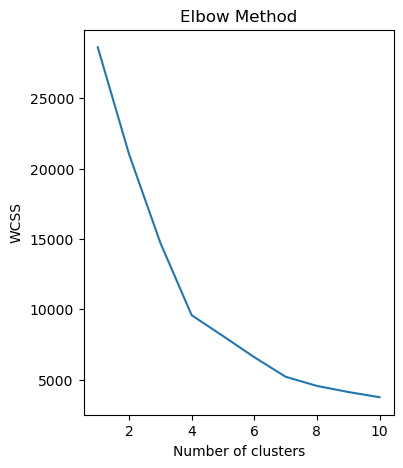

<Figure size 640x480 with 0 Axes>

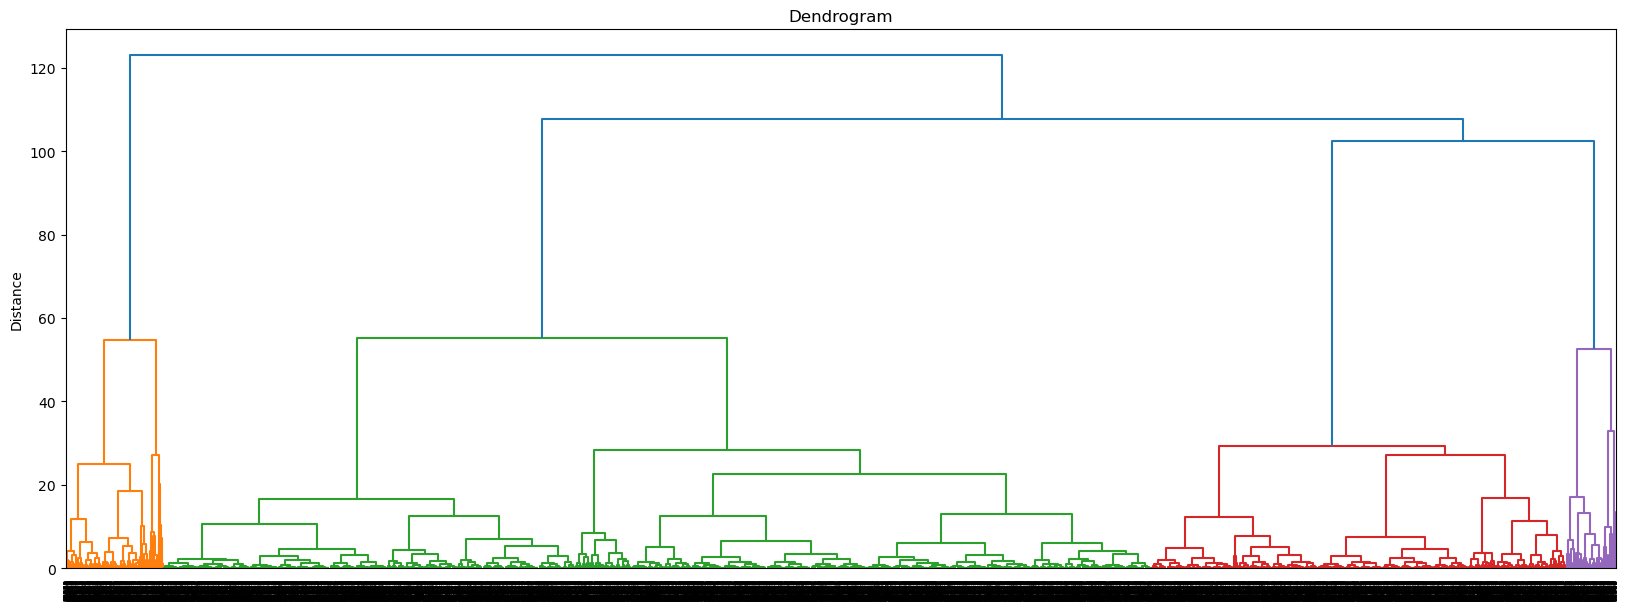

In [12]:
clustered_dendro_df = create_dendrogram(subset_data,'standardscaler','ward')

,frequency,monetary,recency
Cluster,,,
1,2.217028,207.492037,234.005008
2,1.000000,99.148882,161.193193
3,1.000000,108.433801,438.729370
4,1.000000,979.476349,233.605263


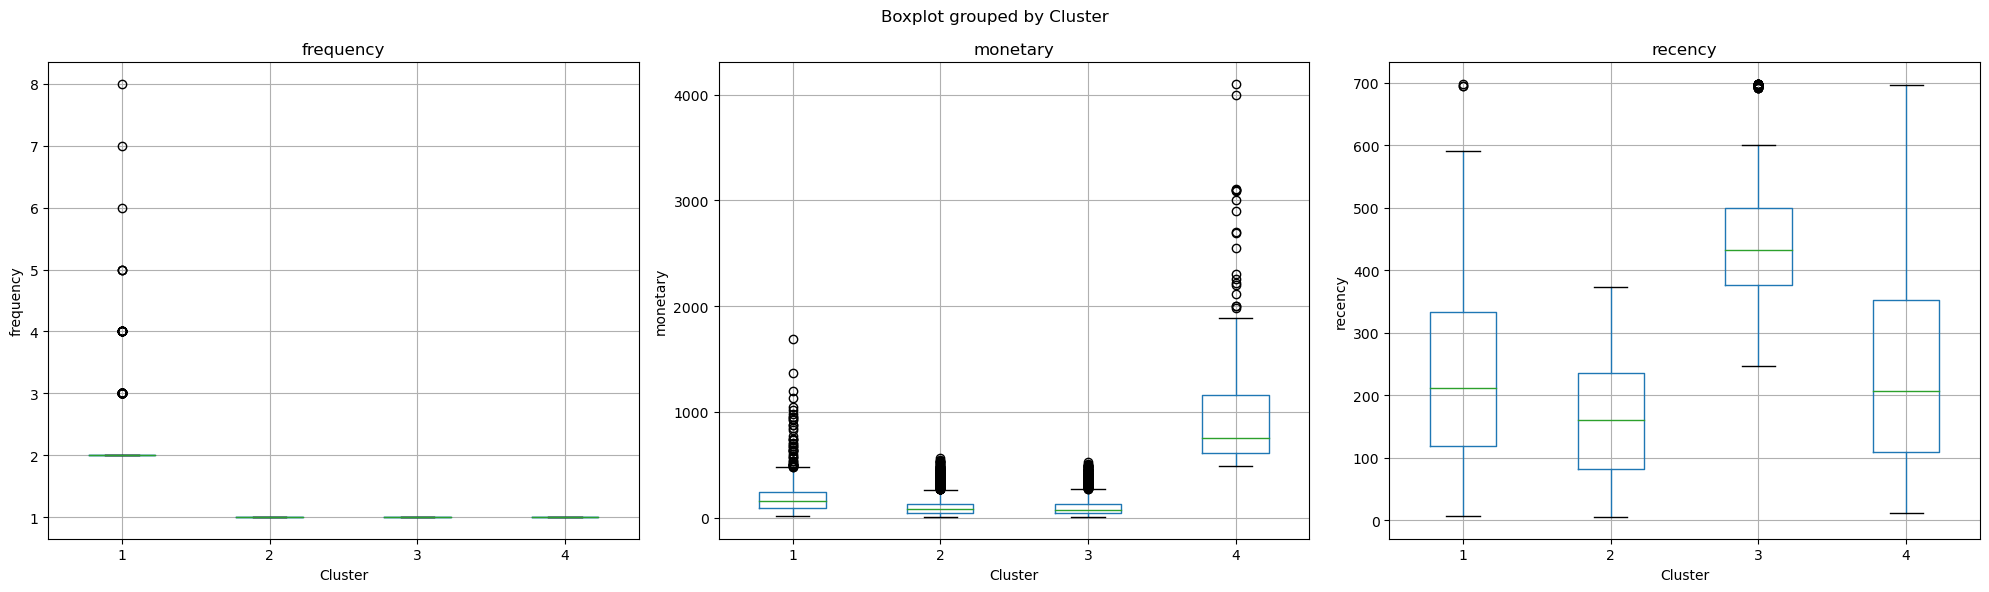

In [13]:
exploreCentroids(clustered_dendro_df)

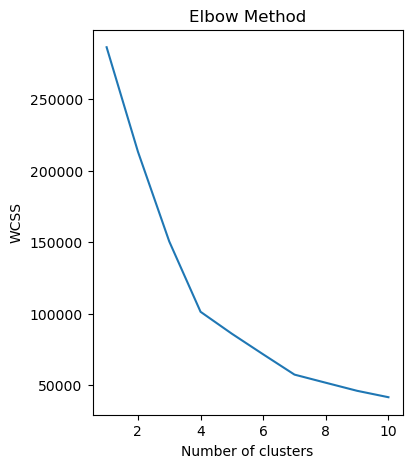

In [14]:
clustered_kmeans_df = kmeansClustering(clustering_data_min,'standardscaler')

,frequency,monetary,recency
Cluster,,,
1,1.039874,1026.537039,245.058824
2,2.247114,195.616766,234.061910
3,1.000000,103.591801,132.507019
4,1.000000,104.005871,392.881500


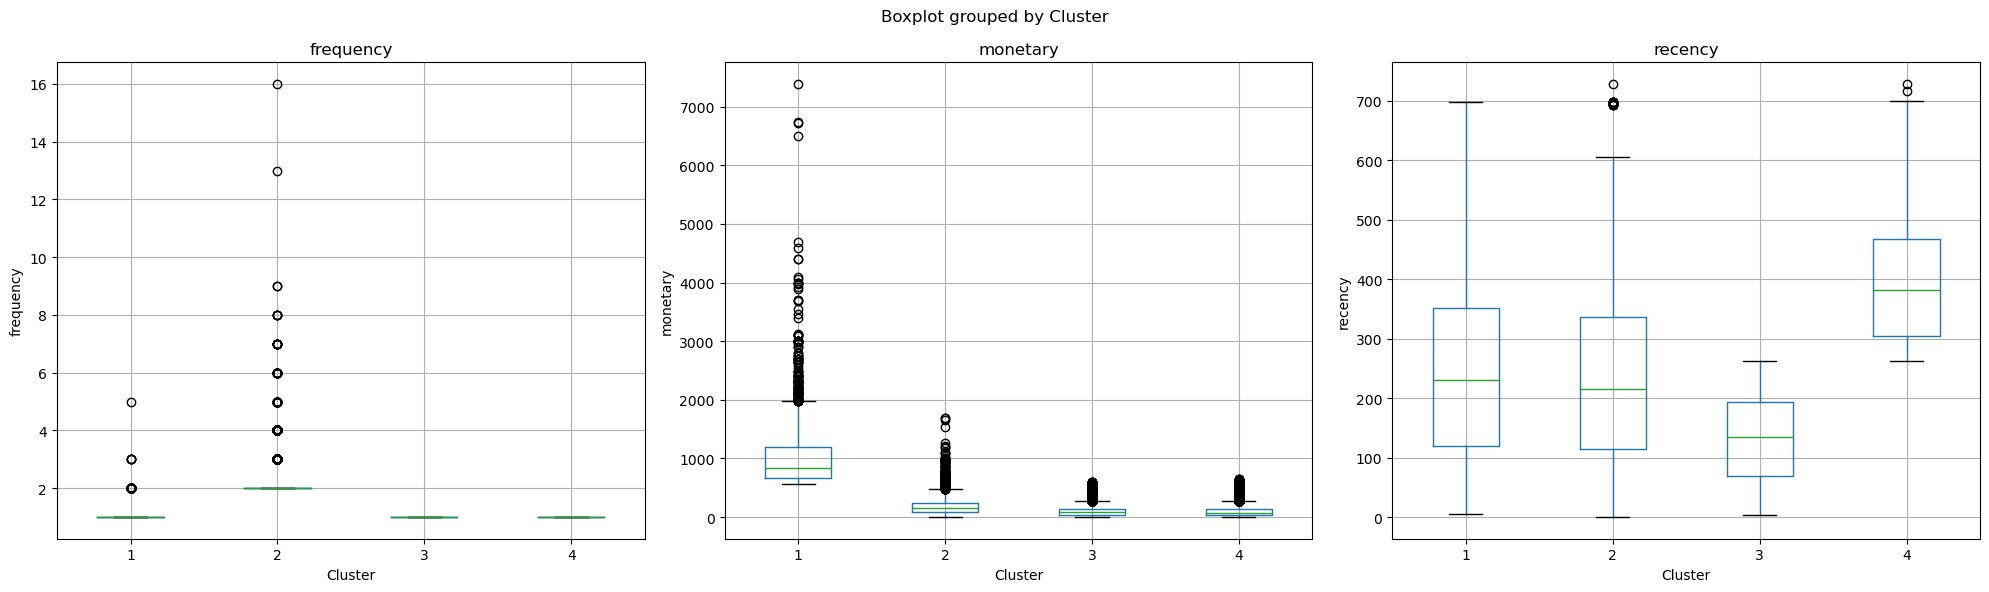

In [15]:
exploreCentroids(clustered_kmeans_df)

In [16]:
compare_clustering_results(clustered_kmeans_df,clustered_dendro_df)

Silhouette Score (df1): 0.3377844910974694
Silhouette Score (df2): 0.33623064850691853


The result of both methods bring very similar results
----------------------------
**In both case we see 4 distincs clusters**
- A cluster with our loyal customers buying often
- A cluster with our spenders 
- A cluster with sleeping clients
- A cluter of recent first time buyers

-----------------------------

**Let's now add more feature like the review score and frequency to see if we can do better**

In [17]:
base_data

,customer_unique_id,frequency,monetary,review_score,max_purchase_timestamp,min_purchase_timestamp,time_difference,frequency_per_time
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,5.0,2018-05-10 10:56:27,2018-05-10 10:56:27,0,0.0
1,938638b4e8e194db5e20e3deb15a975f,1,22.99,5.0,2018-08-15 16:55:14,2018-08-15 16:55:14,0,0.0
2,9379341fe9970e4e730fd4de16b0b9eb,1,89.49,5.0,2017-09-04 14:39:30,2017-09-04 14:39:30,0,0.0
3,937957cb1bc6deab6796d96f528d849d,1,164.90,5.0,2018-08-07 23:46:11,2018-08-07 23:46:11,0,0.0
4,937a668a37820388e591a0bfc2392d08,1,65.00,5.0,2017-10-23 16:26:56,2017-10-23 16:26:56,0,0.0
...,...,...,...,...,...,...,...,...
95415,ff905cb313cb121a840dafe5a7a9170f,1,179.49,NaN,2017-12-06 13:46:32,2017-12-06 13:46:32,0,0.0
95416,ffb3cbd5e1e507679e2db84c515410a5,1,94.90,NaN,2018-08-15 20:24:56,2018-08-15 20:24:56,0,0.0
95417,ffca77d46c6d7d815549a5e4482dba2f,1,141.64,NaN,2018-03-22 16:17:04,2018-03-22 16:17:04,0,0.0
95418,ffe0c10afc687bcf34a0451f2b87dd9b,1,179.00,NaN,2018-02-08 21:58:29,2018-02-08 21:58:29,0,0.0


In [18]:
clustering_data_max = clustering_data_min.copy()
clustering_data_max = pd.merge(clustering_data_max,base_data[['review_score']],left_index=True, right_index=True)
clustering_data_max = clustering_data_max.dropna()
clustering_data_max

,frequency,monetary,recency,review_score
0,1,129.90,115,5.0
1,1,22.99,18,5.0
2,1,89.49,363,5.0
3,1,164.90,26,5.0
4,1,65.00,314,5.0
...,...,...,...,...
94716,1,49.90,201,1.0
94717,1,99.90,26,1.0
94718,3,82.88,219,1.0
94719,1,229.90,560,1.0


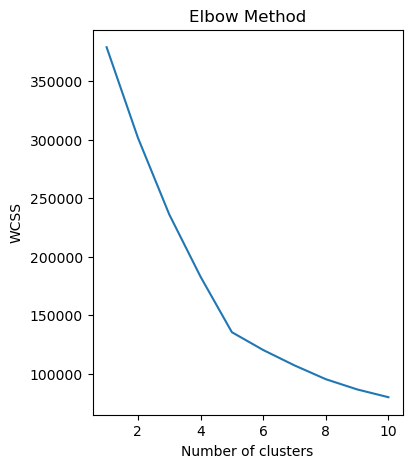

In [30]:
clustered_kmeans_df_max = kmeansClustering(clustering_data_max,'standardscaler')

,frequency,monetary,recency,review_score
Cluster,,,,
1,1.000000,122.851013,126.296041,4.678714
2,1.000000,136.751179,244.348892,1.634297
3,1.000000,127.508520,397.202174,4.636716
4,2.236946,235.430372,233.567810,3.735624


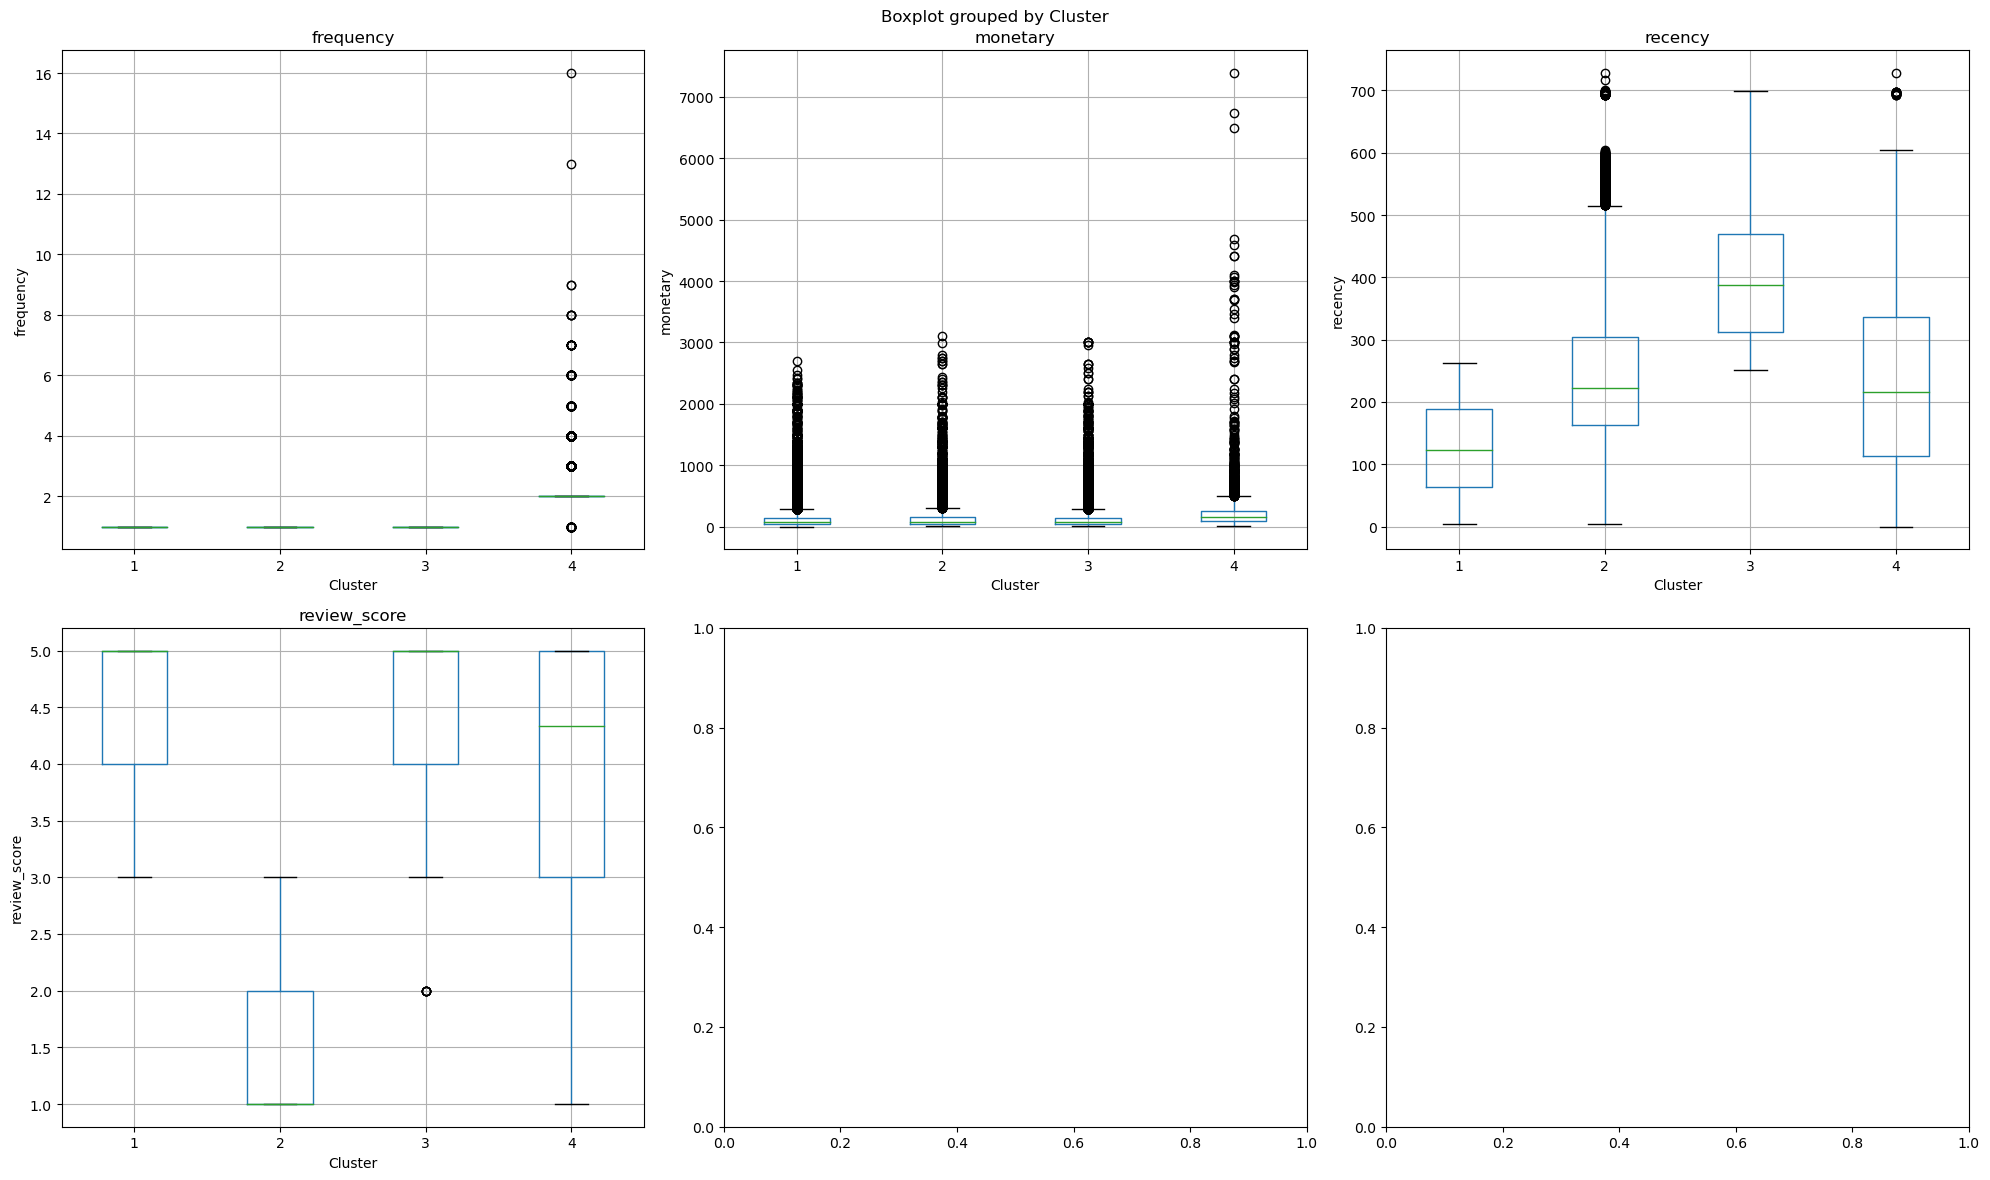

In [31]:
exploreCentroids(clustered_kmeans_df_max)

In [21]:
compare_clustering_results(clustered_dendro_df,clustered_kmeans_df_max)

Silhouette Score (df1): 0.33623064850691853
Silhouette Score (df2): 0.0230197762726885


**We are not doing well adding those new data so let's stick to the RFM**

--------------------------------

**Now that we have our model, let's see how long it stays relevent**